In [1]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
## Download the csv files
#########################
df = pd.read_csv('house-prices.csv')
df_unseen = pd.read_csv('house-prices-test.csv')

print('df shape = ',df.shape)
print('df_test shape = ',df_unseen.shape)

df shape =  (2430, 82)
df_test shape =  (500, 81)


Note that we have 81 columns in the second DataFrame because 'SalePrice' is missing.

In [3]:
## Print the first five rows
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


The Order and PID variables are identifiers. They are not useful to predict house prices, so we can drop these two variables.

In [4]:
## Drop these two columns
#########################
df.drop(['Order','PID'],axis=1,inplace=True)
df_unseen.drop(['Order','PID'],axis=1,inplace=True)

# Split columns

Before cleaning the data, which means handle with missing/incorrect/inconsistency values and outliers, it seems to be usefull to split the columns according to their different nature. For example numerical, categorical.

In [5]:
## Numerical columns
####################

numerical_col = df._get_numeric_data().columns

## Print its length
print('Number of numerical columns = {}'.format(len(numerical_col)))

Number of numerical columns = 37



Using the documentation.txt file, we classify the categorical columns into ordinal, nominal and discrete.

In [6]:
## Nominal columns
##################
nominal_col = ['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config',
              'Neighborhood','Condition 1','Condition 2','Bldg Type','House Style',
               'Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type',
               'Foundation','Heating','Central Air','Garage Type','Misc Feature',
               'Sale Type','Sale Condition']

## Ordinal columns
##################
ordinal_col = ['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond',
               'Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure',
              'BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual',
              'Functional','Fireplace Qu','Garage Finish','Garage Qual','Garage Cond',
              'Paved Drive','Pool QC','Fence']

## Discrete columns
###################
discrete_col = ['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath',
               'Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces',
                'Garage Yr Blt','Garage Cars','Mo Sold','Yr Sold']

If we sum the length of each categorical columns + the numerical one, then we get 97 ! We can look at the intersection of the above three lists with the numerical one.

In [7]:
## Compute the different intersections
######################################

set_num = set(numerical_col)
set_nom = set(nominal_col)
set_ord = set(ordinal_col)
set_disc = set(discrete_col)
A = set_num.intersection(set_nom)
B = set_num.intersection(set_ord)
C = set_num.intersection(set_disc)

print('Intersection with Nominal = {}'.format(A))
print('Intersection with Ordinal = {}'.format(B))
print('Intersection with Discrete = {}'.format(C))

Intersection with Nominal = {'MS SubClass'}
Intersection with Ordinal = {'Overall Qual', 'Overall Cond'}
Intersection with Discrete = {'Bedroom AbvGr', 'Full Bath', 'Year Built', 'TotRms AbvGrd', 'Mo Sold', 'Half Bath', 'Fireplaces', 'Kitchen AbvGr', 'Garage Yr Blt', 'Bsmt Half Bath', 'Yr Sold', 'Year Remod/Add', 'Bsmt Full Bath', 'Garage Cars'}


In [8]:
## Actualizing the numerical columns
####################################
set_num = set_num - (A.union(B.union(C)))
continous_col = list(set_num)

## We create also a continuous list for df_test
continous_col_test = [x for x in continous_col if (x!= 'SalePrice')]

In [9]:
## Size of the union of all columns
###################################
len(nominal_col)+len(ordinal_col)+len(discrete_col)+len(continous_col)

80

# Cleaning data 
                 
Before cleaning the data, we split df into a train and a test set. We clean the data according to the four different categories we established before. For instance, we will handle with missing/incorrect values and remove outliers. For missing values, it is enough to analyze them in the principal one and then fill NaN values in the other df.

In [10]:
## Splitting data
#################
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df,test_size=0.2,random_state=0)


print('df_train : ',df_train.shape)
print('df_test : ',df_test.shape)

df_train :  (1944, 80)
df_test :  (486, 80)


## Nominal features

First of all, let's check if we have incorrect values.

In [11]:
## Loop to list all values of the different nominal columns
###########################################################
for c in nominal_col:
    values =list(df[c].value_counts().index.values)
    print(c+' :',values)

MS SubClass : [20, 60, 50, 120, 30, 70, 160, 80, 90, 190, 85, 75, 45, 180, 40, 150]
MS Zoning : ['RL', 'RM', 'FV', 'RH', 'C (all)', 'A (agr)', 'I (all)']
Street : ['Pave', 'Grvl']
Alley : ['Grvl', 'Pave']
Land Contour : ['Lvl', 'Bnk', 'HLS', 'Low']
Lot Config : ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']
Neighborhood : ['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Gilbert', 'NridgHt', 'Sawyer', 'NWAmes', 'SawyerW', 'Mitchel', 'BrkSide', 'Crawfor', 'IDOTRR', 'Timber', 'NoRidge', 'StoneBr', 'ClearCr', 'SWISU', 'MeadowV', 'BrDale', 'Blmngtn', 'NPkVill', 'Veenker', 'Greens', 'Blueste', 'GrnHill', 'Landmrk']
Condition 1 : ['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']
Condition 2 : ['Norm', 'Feedr', 'Artery', 'PosA', 'RRNn', 'PosN', 'RRAe', 'RRAn']
Bldg Type : ['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon']
House Style : ['1Story', '2Story', '1.5Fin', 'SLvl', 'SFoyer', '2.5Unf', '1.5Unf', '2.5Fin']
Roof Style : ['Gable', 'Hip', 'Gambrel', 'Flat', 'Man

The MS SubClass are in fact integers for type of dwelling involved in the sale. Since the numbers seem to be arbitrary, this variable should be considered as a discrete one. It seems that there are no incorrect values on these columns.

In [12]:
## Remove and put MS SubClass in discrete columns
#################################################
discrete_col.append('MS SubClass')
nominal_col.remove('MS SubClass')

### Deal with missing values

In [13]:
## Number of NaN in each column
###############################
df[nominal_col].isnull().sum()

MS Zoning            0
Street               0
Alley             2267
Land Contour         0
Lot Config           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        20
Foundation           0
Heating              0
Central Air          0
Garage Type        136
Misc Feature      2340
Sale Type            0
Sale Condition       0
dtype: int64

We interpret the NaN values in the columns 'Alley', 'Garage Type' and 'Misc Feature' as 'No such feature' and in 'Mas Vnr Type' as a missing value.
We thus fill NaN values in the first three columns with 'None' and the last one with the most frequent value in df_train.

In [14]:
## Fill missing values
######################

## The first three columns
col = ['Alley','Garage Type','Misc Feature']
## Filling the three df
df_train[col] = df_train[col].fillna(value='None')
df_test[col] = df_test[col].fillna(value='None')
df_unseen[col] = df_unseen[col].fillna(value='None')

## The most frequent value in df_train
Most_freq = df_train['Mas Vnr Type'].value_counts().idxmax()

## Fill with this string
df_train['Mas Vnr Type'] = df_train['Mas Vnr Type'].fillna(value = Most_freq)
df_test['Mas Vnr Type'] = df_test['Mas Vnr Type'].fillna(value = Most_freq)
df_unseen['Mas Vnr Type'] = df_unseen['Mas Vnr Type'].fillna(value = Most_freq)

In [15]:
## We check the final result
############################
print('Nominal NaN values df_train = {}'.format(df_train[nominal_col].isnull().sum().sum()))
print('Nominal NaN values df_test = {}'.format(df_test[nominal_col].isnull().sum().sum()))
print('Nominal NaN values df_unseen = {}'.format(df_unseen[nominal_col].isnull().sum().sum()))

Nominal NaN values df_train = 0
Nominal NaN values df_test = 0
Nominal NaN values df_unseen = 0


## Discrete features

### Find incorrect data

As before, we start by looking at the possible values in each column in order to detect some incorrect ones. For instance an incorrect date.

In [16]:
## Print possible values
########################
for c in discrete_col:
    values =list(df[c].value_counts().index.values)
    print(c+' :',values)

Year Built : [2005, 2006, 2007, 2004, 2003, 1920, 1977, 1976, 1999, 2008, 2002, 1958, 1968, 1954, 1910, 2000, 1998, 1967, 1978, 1972, 1959, 1993, 1970, 1971, 1940, 2001, 1961, 1925, 1997, 1994, 1960, 1965, 1955, 1950, 1962, 1956, 1957, 1963, 1969, 1964, 1966, 1996, 1930, 1900, 1995, 1974, 1980, 1948, 1953, 1992, 1975, 1984, 2009, 1979, 1915, 1990, 1973, 1939, 1926, 1941, 1951, 1952, 1923, 1949, 1922, 1945, 1924, 1988, 1991, 1946, 1947, 1935, 1936, 1986, 1927, 1921, 1981, 1916, 1918, 1914, 1928, 1937, 1929, 1989, 1938, 1987, 1890, 1983, 1985, 1931, 1942, 1912, 1932, 1880, 1934, 1919, 1982, 1917, 1905, 1892, 1901, 1895, 1885, 1907, 1911, 1879, 1893, 1908, 1904, 1902, 2010, 1898, 1896, 1913, 1875]
Year Remod/Add : [1950, 2006, 2007, 2005, 2004, 2000, 2003, 2002, 2008, 1998, 1999, 1995, 1996, 1994, 1976, 2001, 1977, 1997, 1993, 1968, 1970, 1978, 1972, 1967, 1958, 1971, 1975, 1992, 1969, 1991, 1990, 1980, 1960, 1954, 2009, 1965, 1959, 1963, 1979, 1956, 1962, 1961, 1955, 1964, 1984, 1974, 19

In [17]:
## A first incorrect value
##########################
df[df['Garage Yr Blt']>2010][['Garage Yr Blt','Year Built']]

,Garage Yr Blt,Year Built
2219,2207.0,2006


In [18]:
## change 2207 by 2007 in test+train
#####################################
df_train['Garage Yr Blt'].replace(to_replace = {2207.0:2007.0},inplace=True)
df_test['Garage Yr Blt'].replace(to_replace = {2207.0:2007.0},inplace=True)
df_unseen['Garage Yr Blt'].replace(to_replace = {2207.0:2007.0},inplace=True)

We can check that the year of built is less than the year of remod.

In [19]:
(df['Year Built']>df['Year Remod/Add']).sum()

0

We do the same for df_unseen. For instance, we check the three columns involving dates.

In [20]:
np.sort(df_unseen['Garage Yr Blt'].value_counts().index)

array([1895., 1900., 1906., 1910., 1915., 1916., 1918., 1920., 1921.,
       1922., 1923., 1924., 1925., 1926., 1928., 1930., 1931., 1934.,
       1935., 1937., 1938., 1939., 1940., 1941., 1942., 1945., 1946.,
       1947., 1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955.,
       1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.])

In [21]:
np.sort(df_unseen['Year Built'].value_counts().index)

array([1872, 1880, 1882, 1890, 1895, 1900, 1905, 1906, 1908, 1910, 1912,
       1915, 1916, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1928, 1929, 1930, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010])

In [22]:
np.sort(df_unseen['Year Remod/Add'].value_counts().index)

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010])

In [23]:
df_unseen[(df_unseen['Year Built']>df_unseen['Year Remod/Add'])][['Year Built',
                                                                'Year Remod/Add']]

,Year Built,Year Remod/Add
182,2002,2001


We have a small inconsistency : We have to change the year built from 2002 to 2001.

In [24]:
df_unseen.loc[182,'Year Built'] = 2001

## Check if it worked
df_unseen.loc[182,'Year Built']

2001

### Dealing with NaN values

In [25]:
## Number of NaN values
#######################
df[discrete_col].isnull().sum()

Year Built          0
Year Remod/Add      0
Bsmt Full Bath      2
Bsmt Half Bath      2
Full Bath           0
Half Bath           0
Bedroom AbvGr       0
Kitchen AbvGr       0
TotRms AbvGrd       0
Fireplaces          0
Garage Yr Blt     138
Garage Cars         1
Mo Sold             0
Yr Sold             0
MS SubClass         0
dtype: int64

############################################

We decide to drop the column 'Garage Yr Blt' because it seems to be very correlated to the 'Year Built' one, as shows the following plot:

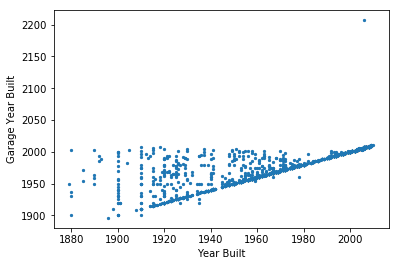

In [26]:
## Correlation between Yr Built and Garage Yr Blt
#################################################
plt.scatter(df['Year Built'].values,df['Garage Yr Blt'].values,s=5)
plt.xlabel('Year Built')
plt.ylabel('Garage Year Built')
plt.show()

In [27]:
## Compute the correlation
##########################
corr = df['Year Built'].corr(df['Garage Yr Blt'])
print('Correlation between the two variables = {:.3f}'.format(corr))

Correlation between the two variables = 0.836


In [28]:
## We drop the column 'Garage Yr Blt'
#####################################
df_train.drop('Garage Yr Blt',axis=1,inplace=True)
df_test.drop('Garage Yr Blt',axis=1,inplace=True)
df_unseen.drop('Garage Yr Blt',axis=1,inplace=True)
discrete_col.remove('Garage Yr Blt')

In [29]:
## Check again null values
##########################
df.drop('Garage Yr Blt',axis=1,inplace=True)
df[discrete_col].isnull().sum()

Year Built        0
Year Remod/Add    0
Bsmt Full Bath    2
Bsmt Half Bath    2
Full Bath         0
Half Bath         0
Bedroom AbvGr     0
Kitchen AbvGr     0
TotRms AbvGrd     0
Fireplaces        0
Garage Cars       1
Mo Sold           0
Yr Sold           0
MS SubClass       0
dtype: int64

In [30]:
## Fill NaN in 'Garage cars' with 0
###################################
df_train['Garage Cars'] = df_train['Garage Cars'].fillna(value=0)
df_test['Garage Cars'] = df_test['Garage Cars'].fillna(value=0)
df_unseen['Garage Cars'] = df_unseen['Garage Cars'].fillna(value=0)

For the two 'Bsmt', we can just check if the two missing values are possibly zero by looking at the two columns 'Full Bath' and 'Half Bath'

In [31]:
(df[df['Bsmt Full Bath'].isnull()])[['Bsmt Full Bath','Bsmt Half Bath','Full Bath',
                                   'Half Bath']]

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath
104,NaN,NaN,1,0
2056,NaN,NaN,3,1


Since it is not the case, we can simply fill these two NaN values with the most frequent one.

In [32]:
## Fill NaN with most frequent value
####################################

bsmt = ['Bsmt Full Bath','Bsmt Half Bath']

for c in bsmt:
    
    ## Consider the most freqent value with respect to the training set
    most_freq = df_train[c].value_counts().idxmax()
    
    ## Fill in the three df
    df_train[c] = df_train[c].fillna(value = most_freq)
    df_test[c] = df_test[c].fillna(value = most_freq)
    df_unseen[c] = df_unseen[c].fillna(value = most_freq)

## Check the result
print('NaN values in train = ',df_train[discrete_col].isnull().sum().sum())
print('NaN values in test = ',df_test[discrete_col].isnull().sum().sum())
print('NaN values in unseen = ',df_unseen[discrete_col].isnull().sum().sum())

NaN values in train =  0
NaN values in test =  0
NaN values in unseen =  0


##############################################

To conclude the analysis of the discrete variables, we decide to consider the two columns involving dates, for instance 'Year Built', 'Year Remod/Add' as continuous features. The reason for this is that we have a lot of different dates.

In [33]:
## Remove/Add 
#############
col = ['Year Built', 'Year Remod/Add']
for c in col:
    discrete_col.remove(c)
    continous_col.append(c)

## Ordinal columns

### Find incorrect data

In [34]:
## Get all possible values of each ordinal feature
##################################################
for c in ordinal_col:
    values =list(df[c].value_counts().index.values)
    print(c+' :',values)

Lot Shape : ['Reg', 'IR1', 'IR2', 'IR3']
Utilities : ['AllPub', 'NoSewr', 'NoSeWa']
Land Slope : ['Gtl', 'Mod', 'Sev']
Overall Qual : [5, 6, 7, 8, 4, 9, 3, 10, 2, 1]
Overall Cond : [5, 6, 7, 8, 4, 3, 9, 2, 1]
Exter Qual : ['TA', 'Gd', 'Ex', 'Fa']
Exter Cond : ['TA', 'Gd', 'Fa', 'Ex', 'Po']
Bsmt Qual : ['TA', 'Gd', 'Ex', 'Fa', 'Po']
Bsmt Cond : ['TA', 'Gd', 'Fa', 'Po', 'Ex']
Bsmt Exposure : ['No', 'Av', 'Gd', 'Mn']
BsmtFin Type 1 : ['GLQ', 'Unf', 'ALQ', 'Rec', 'BLQ', 'LwQ']
BsmtFin Type 2 : ['Unf', 'Rec', 'LwQ', 'BLQ', 'ALQ', 'GLQ']
Heating QC : ['Ex', 'TA', 'Gd', 'Fa', 'Po']
Electrical : ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']
Kitchen Qual : ['TA', 'Gd', 'Ex', 'Fa', 'Po']
Functional : ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']
Fireplace Qu : ['Gd', 'TA', 'Fa', 'Po', 'Ex']
Garage Finish : ['Unf', 'RFn', 'Fin']
Garage Qual : ['TA', 'Fa', 'Gd', 'Po', 'Ex']
Garage Cond : ['TA', 'Fa', 'Po', 'Gd', 'Ex']
Paved Drive : ['Y', 'N', 'P']
Pool QC : ['Ex', 'TA', 'Gd', 'Fa']
Fe

In [35]:
## The same for df_test
#######################
for c in ordinal_col:
    values =list(df_test[c].value_counts().index.values)
    print(c+' :',values)

Lot Shape : ['Reg', 'IR1', 'IR2', 'IR3']
Utilities : ['AllPub']
Land Slope : ['Gtl', 'Mod', 'Sev']
Overall Qual : [5, 6, 7, 8, 4, 9, 3, 2, 10]
Overall Cond : [5, 6, 7, 8, 4, 9, 3, 2]
Exter Qual : ['TA', 'Gd', 'Ex', 'Fa']
Exter Cond : ['TA', 'Gd', 'Fa', 'Ex', 'Po']
Bsmt Qual : ['TA', 'Gd', 'Ex', 'Fa']
Bsmt Cond : ['TA', 'Gd', 'Fa', 'Po']
Bsmt Exposure : ['No', 'Av', 'Gd', 'Mn']
BsmtFin Type 1 : ['Unf', 'GLQ', 'ALQ', 'Rec', 'BLQ', 'LwQ']
BsmtFin Type 2 : ['Unf', 'Rec', 'LwQ', 'BLQ', 'ALQ', 'GLQ']
Heating QC : ['Ex', 'TA', 'Gd', 'Fa']
Electrical : ['SBrkr', 'FuseA', 'FuseF']
Kitchen Qual : ['TA', 'Gd', 'Ex', 'Fa']
Functional : ['Typ', 'Min1', 'Mod', 'Min2', 'Maj1']
Fireplace Qu : ['Gd', 'TA', 'Fa', 'Po', 'Ex']
Garage Finish : ['Unf', 'RFn', 'Fin']
Garage Qual : ['TA', 'Fa', 'Gd']
Garage Cond : ['TA', 'Fa', 'Po', 'Gd']
Paved Drive : ['Y', 'N', 'P']
Pool QC : ['Gd', 'TA']
Fence : ['MnPrv', 'GdPrv', 'GdWo', 'MnWw']


##########################################

There are a priori, after looking carefully in the txt file, no incorrect values 

### Deal with NaN values

In [36]:
df[ordinal_col].isnull().sum()

Lot Shape            0
Utilities            0
Land Slope           0
Overall Qual         0
Overall Cond         0
Exter Qual           0
Exter Cond           0
Bsmt Qual           71
Bsmt Cond           71
Bsmt Exposure       74
BsmtFin Type 1      71
BsmtFin Type 2      72
Heating QC           0
Electrical           1
Kitchen Qual         0
Functional           0
Fireplace Qu      1186
Garage Finish      138
Garage Qual        138
Garage Cond        138
Paved Drive          0
Pool QC           2418
Fence             1941
dtype: int64

########################################

Again, we can have two interpretations of the NaN values : Either the information is missing or it is not include in the house. We may assign 'None' if we think that it is not include and the most frequent value otherwise.

Looking at the meaning of each variable in txt file, I find consistent to split the columns as follows :

In [37]:
col_not_include = ['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1',
                   'BsmtFin Type 2','Fireplace Qu','Garage Finish','Garage Qual',
                   'Garage Cond','Pool QC','Fence']
col_missing = 'Electrical'

In [38]:
## Fill the NaN values
######################

df_train[col_not_include]=df_train[col_not_include].fillna(value='None')
df_test[col_not_include]=df_test[col_not_include].fillna(value='None')
df_unseen[col_not_include]=df_unseen[col_not_include].fillna(value='None')

## The most frequent value on the train set
most_frequent = df_train[col_missing].value_counts().idxmax()

## Fill the three df
df_train[col_missing] = df_train[col_missing].fillna(value = most_frequent)
df_test[col_missing] = df_test[col_missing].fillna(value = most_frequent)
df_unseen[col_missing] = df_unseen[col_missing].fillna(value=most_frequent)

In [39]:
## Check the result
###################
print('NaN values in train = ',df_train[ordinal_col].isnull().sum().sum())
print('NaN values in test = ',df_test[ordinal_col].isnull().sum().sum())
print('NaN values in unseen = ',df_unseen[ordinal_col].isnull().sum().sum())

NaN values in train =  0
NaN values in test =  0
NaN values in unseen =  0


## Continuous columns

### Missing values

In [40]:
df[continous_col].isnull().sum()

Pool Area            0
Mas Vnr Area        20
Enclosed Porch       0
Misc Val             0
Gr Liv Area          0
Low Qual Fin SF      0
3Ssn Porch           0
Wood Deck SF         0
Bsmt Unf SF          1
Garage Area          1
SalePrice            0
Total Bsmt SF        1
Lot Frontage       420
Screen Porch         0
Lot Area             0
1st Flr SF           0
BsmtFin SF 2         1
Open Porch SF        0
BsmtFin SF 1         1
2nd Flr SF           0
Year Built           0
Year Remod/Add       0
dtype: int64

#####################################################

We fill 'Lot Frontage' and 'Mas Vnr Area' with the mean of each column :

In [41]:
## Fill with the mean
#####################

col = ['Lot Frontage', 'Mas Vnr Area']

for c in col:
    
    ## The mean in df_train[c]
    mean = df_train[c].mean()
    
    ## Fill the three df
    df_train[c] = df_train[c].fillna(value = mean)
    df_test[c] = df_test[c].fillna(value = mean)
    df_unseen[c] = df_unseen[c].fillna(value=mean)

In [42]:
## Check the Bsmt
#################
BSMT = [col for col in df.columns if 'Bsmt' in col]
(df_train[df_train['BsmtFin SF 1'].isnull()])[BSMT]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
104,None,None,None,None,NaN,None,NaN,NaN,NaN,0.0,0.0


From the above observation, we can just assign zero to these NaN values

In [43]:
## The four columns in the continuous ones invloving Bsmt
BSMT = [col for col in continous_col if 'Bsmt' in col]

## Fill NaN with 0
for bsmt in BSMT:
    df_train[bsmt] = df_train[bsmt].fillna(value = 0)
    df_test[bsmt] = df_test[bsmt].fillna(value=0)
    df_unseen[bsmt] = df_unseen[bsmt].fillna(value=0)

We can proceed in a similar way for the garage

In [44]:
df_train[df_train['Garage Area'].isnull()][['Garage Area','Garage Cars']]

,Garage Area,Garage Cars
1565,NaN,0.0


Hence we fill this NaN value with zero

In [45]:
df_train['Garage Area'] = df_train['Garage Area'].fillna(value = 0)
df_test['Garage Area'] = df_test['Garage Area'].fillna(value = 0)
df_unseen['Garage Area'] = df_unseen['Garage Area'].fillna(value = 0)

We verify that we treated all NaN values

In [46]:
print('NaN in df_train : ',df_train[continous_col].isnull().sum().sum())
print('NaN in df_test : ',df_test[continous_col_test].isnull().sum().sum())
print('NaN in df_unseen : ',df_unseen[continous_col_test].isnull().sum().sum())

NaN in df_train :  0
NaN in df_test :  0
NaN in df_unseen :  0


# Investigate Outliers

Of course we investigate outliers on the training df. Before this, it is a good idea to apply log-transform to skew variables.

## Apply log-transform

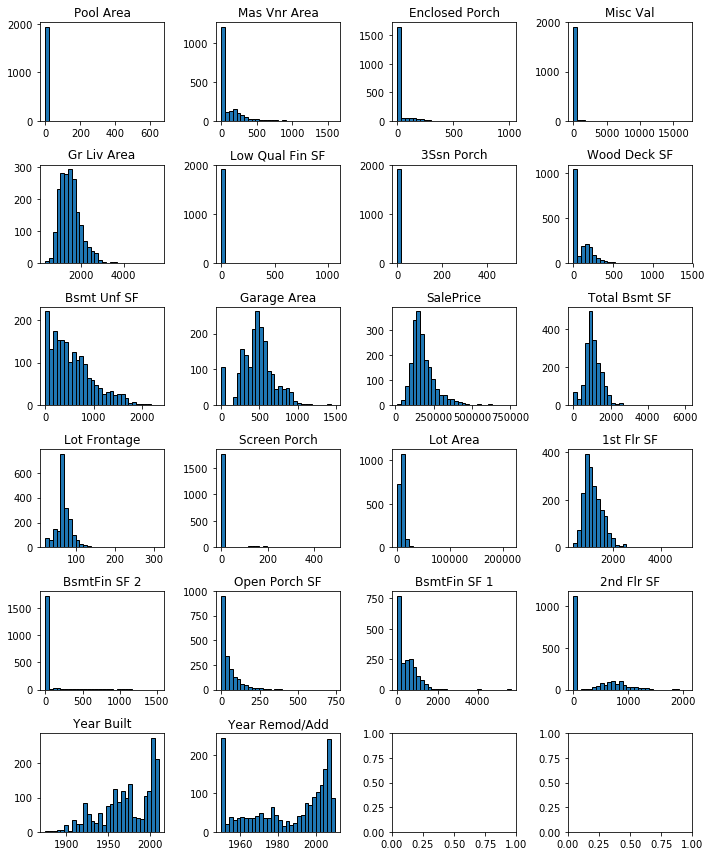

In [47]:
## Plot the distributions using histograms
##########################################
fig, axes = plt.subplots(6,4,figsize=(10,12))

for c,ax in zip(continous_col,axes.ravel()):
    ax.hist(df_train[c].values,bins=30,edgecolor='black')
    ax.set_title(c)
plt.tight_layout()
plt.show()

After looking at each distribution, we decide that the following columns look skew :

In [48]:
## Skewed columns
#################
skewed_cols = ['SalePrice','1st Flr SF','Open Porch SF','2nd Flr SF','Mas Vnr Area',
               'Lot Area','Lot Frontage', 'Total Bsmt SF','Bsmt Unf SF','Wood Deck SF',
               'Year Built','Gr Liv Area','BsmtFin SF 1','Year Remod/Add','Garage Area']

We now apply the logarithm transformation to each of them and plot their new shapes to see if it improves the symmetry of their distribution.

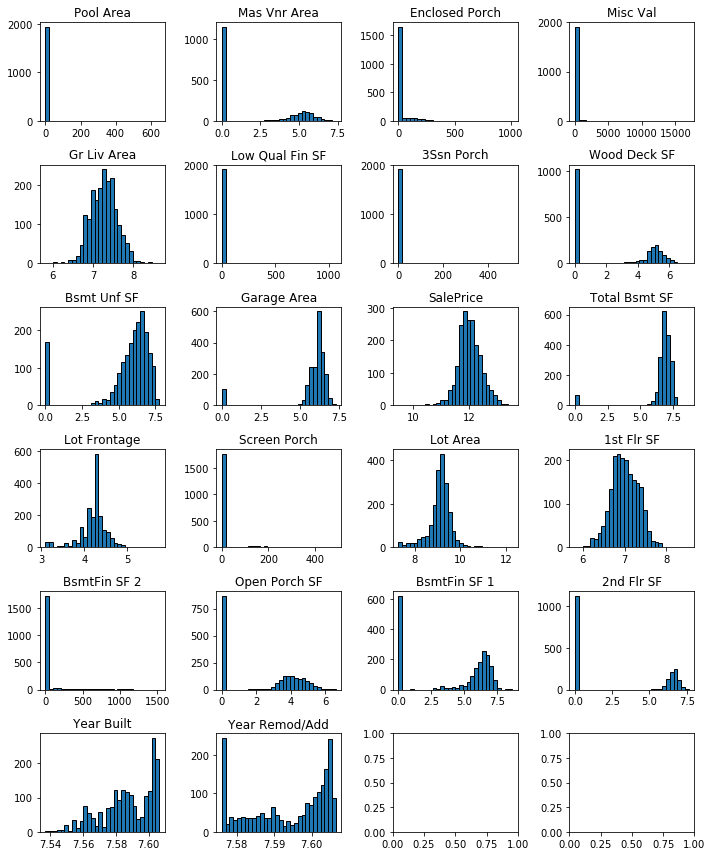

In [49]:
## Testing the log-transformation
#################################

def Log_transform_test(df):
    df = df.copy()
    
    ## Apply the log on each skewed column
    for c in skewed_cols:
        df[c] = df[c].apply(np.log1p)
        
    ## Create the figure
    fig, axes = plt.subplots(6,4,figsize=(10,12))

    for c,ax in zip(continous_col,axes.ravel()):
        ax.hist(df[c].values,bins=30,edgecolor='black')
        ax.set_title(c)
    plt.tight_layout()
    plt.show() 

Log_transform_test(df_train)

After looking at their different shape, we finally decide to apply log-transform to the following columns :

In [50]:
log_transform_cols = ['SalePrice','1st Flr SF','Open Porch SF','Mas Vnr Area',
               'Lot Area','Lot Frontage', 'Total Bsmt SF','Bsmt Unf SF','Wood Deck SF',
               'Gr Liv Area','BsmtFin SF 1']

In [51]:
## Apply log_transform
######################
df_train[log_transform_cols] = df_train[log_transform_cols].applymap(np.log1p)
df_test[log_transform_cols] = df_test[log_transform_cols].applymap(np.log1p)

## Remove 'SalePrice' be cause it is not in df_unseen
log_transform_cols.remove('SalePrice')
df_unseen[log_transform_cols] = df_unseen[log_transform_cols].applymap(np.log1p)

## Outliers
  

We need a reasonnable criterion to decide which row is considered as an outlier. By reasonnable, we mean that we have a few number of outliers (with respect to a given criterion) compared to the total number of observations. 

Two parameters seem to be import for the criterion : the threshold of the z-score and, for a given row, the number of columns having |z-score| > threshold. Let's investigate the number of outliers when these parameters vary.

We will also inverstigate among the columns which look rather symmetric.

In [52]:
## Investigate Criterion ##
##########################

## Number of columns
sym_cols = ['SalePrice','1st Flr SF','Lot Area','Lot Frontage', 'Total Bsmt SF','Gr Liv Area']
n = len(sym_cols)

## The DataFrame containing z_scores
z_scores = (df_train[sym_cols]-df_train[sym_cols].mean())/df_train[sym_cols].std()

## The dictionnary to store the results
Number_outliers = {'Number of columns':np.arange(1,n+1)} 

## Fix the threshold
for thresh in np.linspace(0,5,num=11):
    
    ## Store the number of outliers with number_col varying
    number_outliers = []
    
    ## fix the number of columns, i.e. we consider as an outlier a row having at least 
    ## number_col z_scores greater than thresh in absolute values
    for number_col in range(1,n+1):
        
        ## The DataFrame contining boolean informations concerning the threshold
        bool_frame = np.abs(z_scores)>thresh
        
        ## The Series telling if a row contains more than number_col extreme values
        bool_series = (bool_frame.sum(axis=1)>= number_col)
        
        ## Number of rows considered as outliers
        nb_outliers = bool_series.sum()
        
        ## Store the value in an array
        number_outliers.append(nb_outliers)
    
    ## Add the array to the dictionnary
    Number_outliers['Thresh = '+str(thresh)] = number_outliers

## Store all the result in a DataFrame
Outliers_results = pd.DataFrame(Number_outliers)  
Outliers_results.set_index('Number of columns',inplace=True)

In [53]:
Outliers_results.head(6)

,Thresh = 0.0,Thresh = 0.5,Thresh = 1.0,Thresh = 1.5,Thresh = 2.0,Thresh = 2.5,Thresh = 3.0,Thresh = 3.5,Thresh = 4.0,Thresh = 4.5,Thresh = 5.0
Number of columns,,,,,,,,,,,
1,1944,1891,1348,736,368,216,162,82,72,72,68
2,1944,1614,747,332,145,79,44,6,3,1,1
3,1944,1139,355,128,51,22,5,2,1,0,0
4,1944,630,136,36,6,3,3,2,0,0,0
5,1944,294,31,6,0,0,0,0,0,0,0
6,1944,95,2,0,0,0,0,0,0,0,0


The numbers inside the DataFrame have the following meaning : Given a Threshold thresh and a number of columns nb_col, we define an outlier as a row having more than nb_col with |z_score| > thresh. The associated value is therefore the number of outliers with respect to this definition.

Considering the normal distribution as a reference for detecting outliers with the usual threshold of 2, the proportion of outliers among the total number of observations should be about 5%. Let's apply the %-map to the above DataFrame, followed by fixing in each column the closest value to 5%.

In [54]:
## Apply percentage to the DataFrame
####################################
def perc(x):
    n = df.shape[0] ## number of observations
    p = round((x/n)*100,2)
    return p
Outliers_results = Outliers_results.applymap(perc)

# Consider the distance from each point to 5
Outliers_results = np.abs(Outliers_results-5) 

## This function return x if the value is the minimum and '-' otherwise
def delta(x,y):
    if x==y:
        return x
    else:
        return '-'

## Apply the delta function to each entry
#########################################
def f(series):
    def g(y):
        return delta(y,series.min())
    return series.apply(g)

for col in Outliers_results.columns:
    Outliers_results[col]= f(Outliers_results[col])

In [55]:
Outliers_results.head(6)

,Thresh = 0.0,Thresh = 0.5,Thresh = 1.0,Thresh = 1.5,Thresh = 2.0,Thresh = 2.5,Thresh = 3.0,Thresh = 3.5,Thresh = 4.0,Thresh = 4.5,Thresh = 5.0
Number of columns,,,,,,,,,,,
1,75.0,-,-,-,-,-,1.67,1.63,2.04,2.04,2.2
2,75.0,-,-,-,0.97,1.75,-,-,-,-,-
3,75.0,-,-,0.27,-,-,-,-,-,-,-
4,75.0,-,0.6,-,-,-,-,-,-,-,-
5,75.0,-,-,-,-,-,-,-,-,-,-
6,75.0,1.09,-,-,-,-,-,-,-,-,-


We finally decide to define an outliers as an observation having more (or equal) than 2 column with z-score greater than 2.5

In [56]:
## Boolean Frame 
bool_frame = (np.abs(z_scores)>2)

## Boolean indices
bool_series = (bool_frame.sum(axis=1) >= 2)

## Take off outliers
df_train = df_train[~bool_series]

In [57]:
## Reset Index
df_train.reset_index(drop=True,inplace=True)

In [58]:
df_train.shape

(1799, 79)

In [59]:
## We create new csv_files
##########################
df_train.to_csv('house-prices_cleaned_train.csv',index=False, encoding='utf-8')
df_test.to_csv('house-prices-test_cleaned_test.csv',index=False, encoding='utf-8')
df_unseen.to_csv('house-prices_cleaned_unseen.csv',index=False, encoding='utf-8')